In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("renewable_predicitons") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

In [4]:
path = 'hdfs://namenode:9000'
energy_edited = spark.read.csv(path + '/edata.csv', header=True, inferSchema=True)
energy = spark.read.csv(path + '/edatauc.csv', header=True, inferSchema=True)
df_weather = spark.read.csv(path + '/wdata.csv', header=True, inferSchema=True)

# Optional: Cache the DataFrames if you'll be using them multiple times
energy_edited.cache()
energy.cache()
df_weather.cache()

DataFrame[dt_iso: timestamp, city_name: string, temp: double, temp_min: double, temp_max: double, pressure: int, humidity: int, wind_speed: int, wind_deg: int, rain_1h: double, rain_3h: double, snow_3h: double, clouds_all: int, weather_id: int, weather_main: string, weather_description: string, weather_icon: string]

In [3]:
energy.show()

+-------------------+------------------+------------------------------------+----------------------------------+---------------------+---------------------------+---------------------+---------------------------+----------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+-----------------+------------------+----------------+--------------------------+----------------+----------------+------------------------+-----------------------+------------------------+-------------------------------+-------------------+-----------------+---------------+------------+
|               time|generation biomass|generation fossil brown coal/lignite|generation fossil coal-derived gas|generation fossil gas|generation fossil hard coal|generation fossil oil|generation fossil oil shale|generation fossil peat|generation geothermal|generation hydro pumped storage consumption|generation hydro run-of-river and

# Pre-processing

## Energy Preprocessing


In [4]:
columns_to_drop = ['generation fossil coal-derived gas', 'generation fossil oil shale',
                   'generation fossil peat', 'generation geothermal',
                   'generation hydro pumped storage aggregated', 'generation marine',
                   'generation wind offshore', 'forecast wind offshore eday ahead',
                   'total load forecast', 'forecast solar day ahead',
                   'forecast wind onshore day ahead']

energy = energy.drop(*columns_to_drop)
energy.printSchema()
print(f"Number of rows: {energy.count()}")
print(f"Number of columns: {len(energy.columns)}")


root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: integer (nullable = true)
 |-- generation fossil brown coal/lignite: integer (nullable = true)
 |-- generation fossil gas: integer (nullable = true)
 |-- generation fossil hard coal: integer (nullable = true)
 |-- generation fossil oil: integer (nullable = true)
 |-- generation hydro pumped storage consumption: integer (nullable = true)
 |-- generation hydro run-of-river and poundage: integer (nullable = true)
 |-- generation hydro water reservoir: integer (nullable = true)
 |-- generation nuclear: integer (nullable = true)
 |-- generation other: integer (nullable = true)
 |-- generation other renewable: integer (nullable = true)
 |-- generation solar: integer (nullable = true)
 |-- generation waste: integer (nullable = true)
 |-- generation wind onshore: integer (nullable = true)
 |-- total load actual: integer (nullable = true)
 |-- price day ahead: double (nullable = true)
 |-- price actual: double (nullable = true

In [5]:
# Convert time to datetime and handle as timestamp column
from pyspark.sql.functions import col, to_timestamp, isnan, when, count, sum as spark_sum
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, lead, coalesce

In [6]:
# Convert time column to timestamp (equivalent to pd.to_datetime)
energy = energy.withColumn('time', to_timestamp(col('time')))

# Check for null values (equivalent to isnull().sum())
null_counts = energy.select([count(when(col(c).isNull(), c)).alias(c) for c in energy.columns])
null_counts.show()

+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+--------------------

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_series_spark(df, column=None, ylabel=None, title=None, start=0, end=None):
    """
    Plot time series from Spark DataFrame
    Note: This converts to Pandas for plotting - use only for small datasets or samples
    """
    # Order by time and collect data
    df_ordered = df.orderBy('time')
    
    if end:
        df_sample = df_ordered.limit(end)
    else:
        df_sample = df_ordered
    
    # Convert to Pandas for plotting
    pdf = df_sample.toPandas()
    pdf = pdf.set_index('time')
    
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    
    if column and column in pdf.columns:
        ax.plot(pdf[column][start:end if end else len(pdf)])
        ax.set_ylabel(ylabel, fontsize=16)
    
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

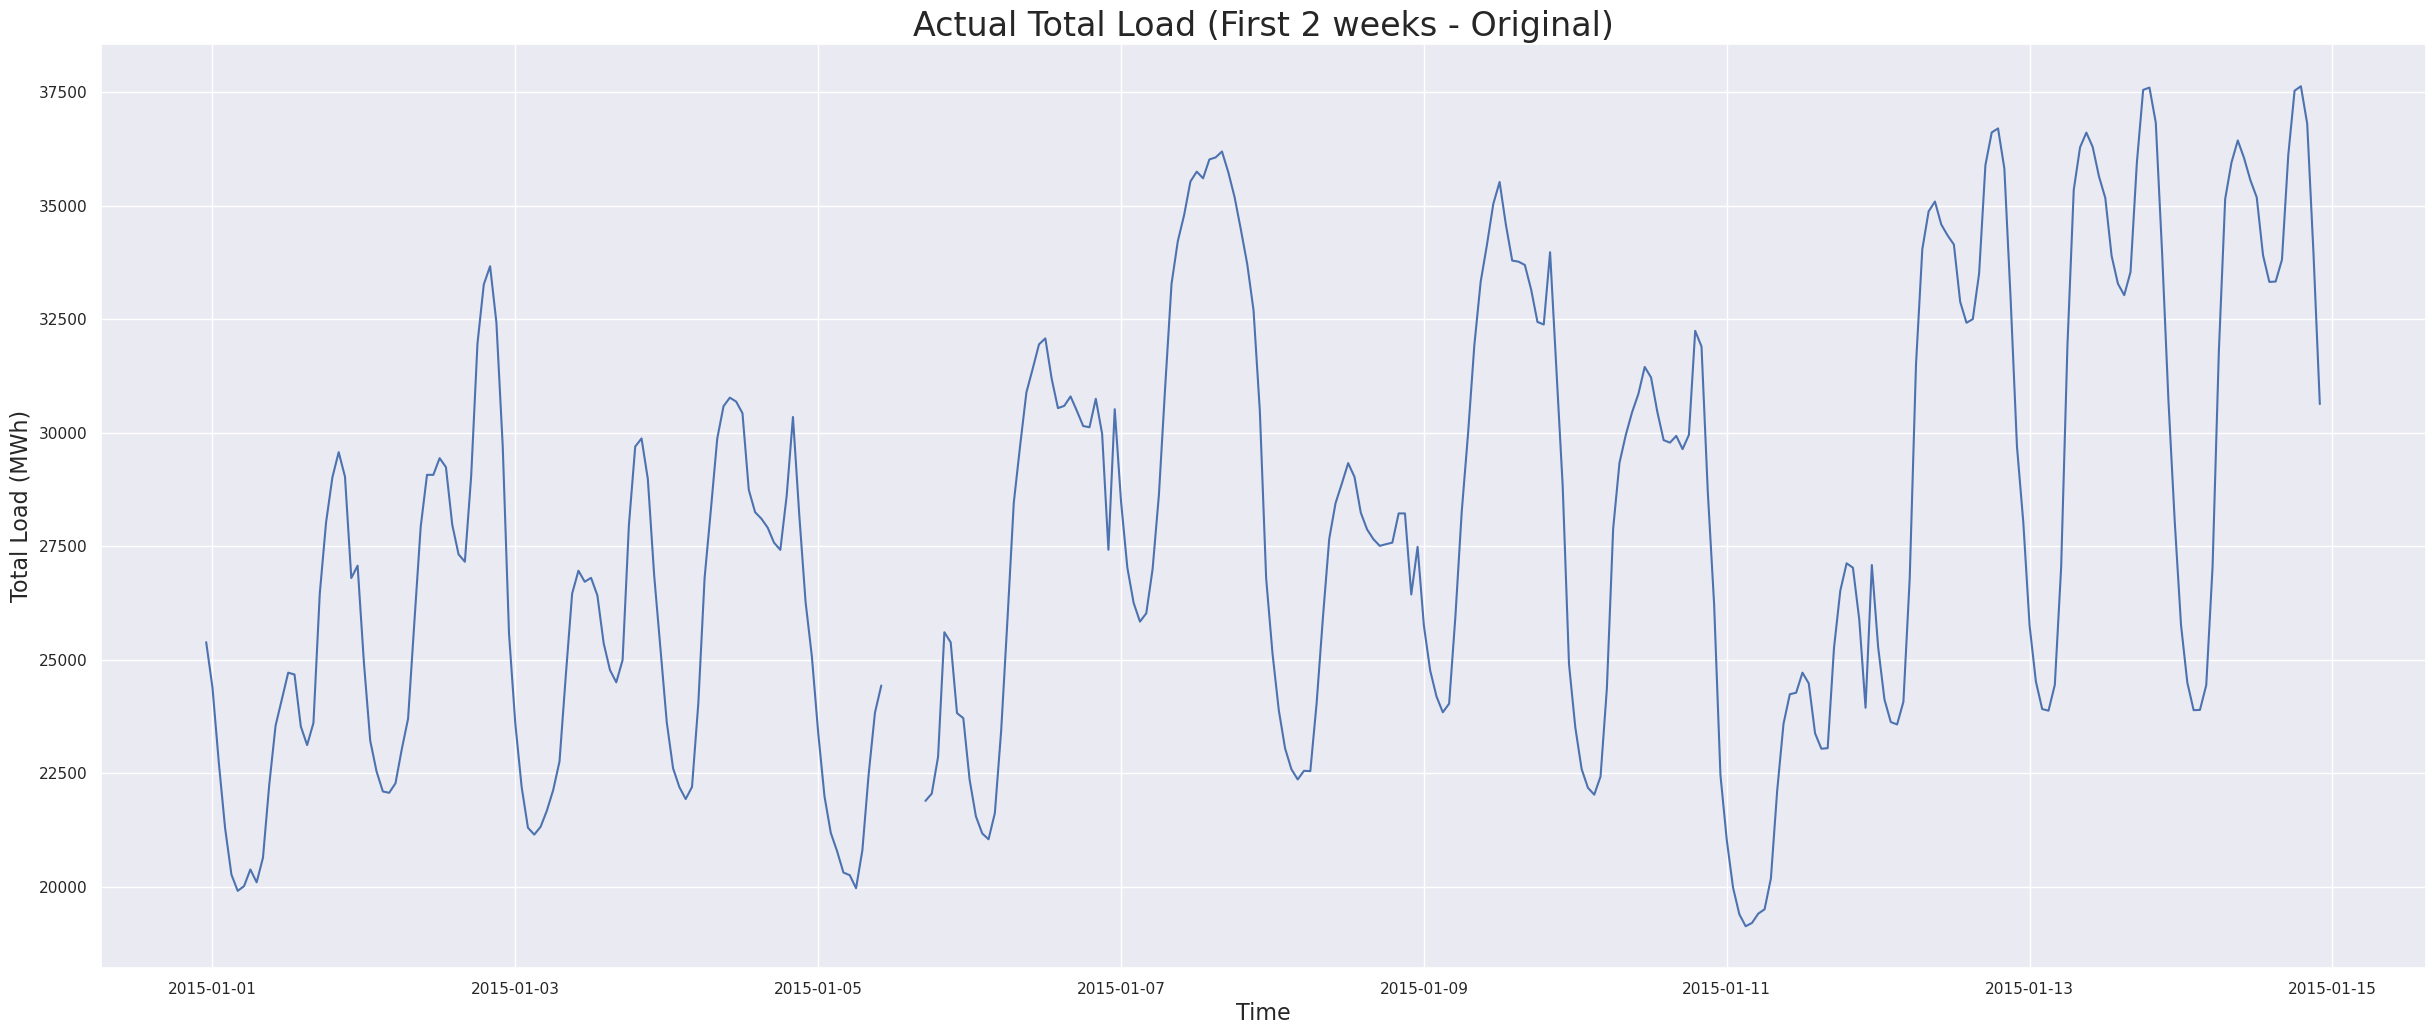

In [8]:
# Plot first 2 weeks of data (24*7*2 = 336 hours)
ax = plot_series_spark(df=energy, column='total load actual', 
                      ylabel='Total Load (MWh)',
                      title='Actual Total Load (First 2 weeks - Original)', 
                      end=336)
plt.show()

In [9]:
# # Fill null values using interpolation (Spark approach)
# # Note: Spark doesn't have direct interpolation like pandas, so we use window functions
# from pyspark.sql.functions import avg

# # Create window for interpolation
# window_spec = Window.orderBy('time').rowsBetween(-1, 1)

# # Apply interpolation to numeric columns (excluding time)
# numeric_cols = [col_name for col_name, col_type in energy.dtypes 
#                 if col_type in ['double', 'float', 'int', 'bigint'] and col_name != 'time']

# for col_name in numeric_cols:
#     energy = energy.withColumn(
#         col_name,
#         when(col(col_name).isNull(), 
#              avg(col(col_name)).over(window_spec)
#         ).otherwise(col(col_name))
#     )

In [10]:
# Fill nulls with mean values
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col, when, count

# Get numeric columns (excluding time)
numeric_cols = [col_name for col_name, col_type in energy.dtypes 
                if col_type in ['double', 'float', 'int', 'bigint'] and col_name != 'time']

# Use Imputer to fill nulls with mean (keeping original column names)
imputer = Imputer(
    inputCols=numeric_cols,
    outputCols=numeric_cols,
    strategy="mean"
)

# Fit and transform
energy = imputer.fit(energy).transform(energy)

# Check null counts after filling
null_counts_after = energy.select([count(when(col(c).isNull(), c)).alias(c) for c in energy.columns])
print("Null counts after mean imputation:")
null_counts_after.show()

Null counts after mean imputation:
+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+----+------------------+------------------------------------+---------------------+---------------------------+-------

In [11]:
null_counts_after = energy.select([count(when(col(c).isNull(), c)).alias(c) for c in energy.columns])
print("Null counts after interpolation:")
null_counts_after.show()

Null counts after interpolation:
+----+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+----+------------------+------------------------------------+---------------------+---------------------------+---------

## Weather Preprocessing

In [12]:
df_weather.printSchema()
print(f"Number of rows: {df_weather.count()}")
print(f"Number of columns: {len(df_weather.columns)}")

root
 |-- dt_iso: timestamp (nullable = true)
 |-- city_name: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- wind_speed: integer (nullable = true)
 |-- wind_deg: integer (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- snow_3h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_id: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- weather_icon: string (nullable = true)

Number of rows: 178396
Number of columns: 17


In [13]:
# Convert integer columns to float (equivalent to df_convert_dtypes function)
from pyspark.sql.functions import col, to_timestamp, count, when, countDistinct
from pyspark.sql.types import FloatType

# Get integer columns and convert to float
integer_cols = [col_name for col_name, col_type in df_weather.dtypes 
                if col_type in ['int', 'bigint']]

for col_name in integer_cols:
    df_weather = df_weather.withColumn(col_name, col(col_name).cast(FloatType()))

# Convert dt_iso to datetime and create time column
df_weather = df_weather.withColumn('time', to_timestamp(col('dt_iso')))

# Drop dt_iso column
df_weather = df_weather.drop('dt_iso')

In [14]:
null_count = df_weather.select([count(when(col(c).isNull(), c)).alias(c) for c in df_weather.columns])
total_nulls = sum([df_weather.select(count(when(col(c).isNull(), c))).collect()[0][0] for c in df_weather.columns])
print(f'There are {total_nulls} missing values or NaNs in df_weather.')

# Check for duplicates
total_rows = df_weather.count()
distinct_rows = df_weather.distinct().count()
duplicates = total_rows - distinct_rows
print(f'There are {duplicates} duplicate rows in df_weather based on all columns.')

# Display energy observations count
energy_count = energy.count()
print(f'There are {energy_count} observations in df_energy.')

There are 0 missing values or NaNs in df_weather.
There are 21 duplicate rows in df_weather based on all columns.
There are 35064 observations in df_energy.


In [15]:
# Get unique cities and group by city
cities = df_weather.select('city_name').distinct().rdd.map(lambda x: x[0]).collect()

for city in cities:
    city_count = df_weather.filter(col('city_name') == city).count()
    print(f'There are {city_count} observations in df_weather about city: {city}.')

# Get unique weather descriptions
weather_descriptions = df_weather.select('weather_description').distinct().rdd.map(lambda x: x[0]).collect()
print("Unique weather descriptions:")
for desc in weather_descriptions:
    print(desc)

# Drop weather-related columns
columns_to_drop = ['weather_main', 'weather_id', 'weather_description', 'weather_icon']
df_weather = df_weather.drop(*columns_to_drop)

There are 36267 observations in df_weather about city: Madrid.
There are 35145 observations in df_weather about city: Valencia.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35951 observations in df_weather about city: Bilbao.
There are 35557 observations in df_weather about city: Seville.
Unique weather descriptions:
fog
drizzle
very heavy rain
proximity shower rain
few clouds
heavy intensity shower rain
haze
light rain
light intensity drizzle
light intensity shower rain
proximity thunderstorm
broken clouds
overcast clouds
light snow
scattered clouds
thunderstorm with rain
thunderstorm with heavy rain
heavy intensity drizzle
thunderstorm with light rain
heavy intensity rain
moderate rain
light intensity drizzle rain
sky is clear
shower rain
mist
thunderstorm
smoke
ragged shower rain
light thunderstorm
proximity moderate rain
shower sleet
sleet
rain and snow
light shower sleet
snow
light rain and snow
light shower snow
heavy snow
rain and drizzle
dust
pro

In [16]:
# Get weather columns (excluding city_name)
df_weather_cols = [col_name for col_name in df_weather.columns if col_name != 'city_name']
print("Weather columns (excluding city_name):")
print(df_weather_cols)

Weather columns (excluding city_name):
['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'time']


## Merging Datasets


In [17]:
# Group weather data by city and merge with energy data
from pyspark.sql.functions import col, count, when, regexp_replace

# Get unique cities
cities = df_weather.select('city_name').distinct().rdd.map(lambda x: x[0]).collect()

# Start with energy dataframe
df_final = energy

In [18]:
# Process each city separately
for city in cities:
    # Filter data for current city
    city_df = df_weather.filter(col('city_name') == city)
    
    # Clean city name for column suffix (remove spaces, quotes, brackets)
    city_str = city.replace(' ', '').replace("'", "").replace('[', '').replace(']', '')
    
    # Add suffix to all columns except time and city_name
    cols_to_rename = [c for c in city_df.columns if c not in ['time', 'city_name']]
    
    for old_col in cols_to_rename:
        city_df = city_df.withColumnRenamed(old_col, f"{old_col}_{city_str}")
    
    # Drop city_name column before merge
    city_df = city_df.drop('city_name')
    
    # Merge with main dataframe (outer join)
    df_final = df_final.join(city_df, on=['time'], how='outer')

# Display columns
print("Final dataframe columns:")
print(df_final.columns)

Final dataframe columns:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'total load actual', 'price day ahead', 'price actual', 'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid', 'pressure_Madrid', 'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid', 'rain_3h_Madrid', 'snow_3h_Madrid', 'clouds_all_Madrid', 'temp_Valencia', 'temp_min_Valencia', 'temp_max_Valencia', 'pressure_Valencia', 'humidity_Valencia', 'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia', 'rain_3h_Valencia', 'snow_3h_Valencia', 'clouds_all_Valencia', 'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona', 'pr

In [19]:
# Check for missing values
total_nulls = sum([df_final.select(count(when(col(c).isNull(), c))).collect()[0][0] for c in df_final.columns])
print(f'There are {total_nulls} missing values or NaNs in df_final.')

# Check for duplicates
total_rows = df_final.count()
distinct_rows = df_final.distinct().count()
duplicates = total_rows - distinct_rows
print(f'\nThere are {duplicates} duplicate rows in df_final based on all columns.')

# Display schema info
df_final.printSchema()
print(f"Number of rows: {df_final.count()}")
print(f"Number of columns: {len(df_final.columns)}")

# Drop rain_3h columns for specific cities
cities_list = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities_list:
    rain_col = f'rain_3h_{city}'
    if rain_col in df_final.columns:
        df_final = df_final.drop(rain_col)

There are 0 missing values or NaNs in df_final.

There are 3504 duplicate rows in df_final based on all columns.
root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: integer (nullable = true)
 |-- generation fossil brown coal/lignite: integer (nullable = true)
 |-- generation fossil gas: integer (nullable = true)
 |-- generation fossil hard coal: integer (nullable = true)
 |-- generation fossil oil: integer (nullable = true)
 |-- generation hydro pumped storage consumption: integer (nullable = true)
 |-- generation hydro run-of-river and poundage: integer (nullable = true)
 |-- generation hydro water reservoir: integer (nullable = true)
 |-- generation nuclear: integer (nullable = true)
 |-- generation other: integer (nullable = true)
 |-- generation other renewable: integer (nullable = true)
 |-- generation solar: integer (nullable = true)
 |-- generation waste: integer (nullable = true)
 |-- generation wind onshore: integer (nullable = true)
 |-- total load actual: in

In [20]:
# Final dataframe
df = df_final
# To show top 5 rows in PySpark
df.show(5)

# df1 = df_final.coalesce(1)
# df1.coalesce(1).write.csv("file:///home/jovyan/work/finalmerged.csv", header=True, mode='overwrite')


+-------------------+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+------------+---------------+---------------+---------------+---------------+-----------------+---------------+--------------+--------------+-----------------+-------------+-----------------+-----------------+-----------------+-----------------+-------------------+-----------------+----------------+----------------+-------------------+--------------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+--------------------+------------+---------------+---------

In [21]:
# Create energy distribution dataframe by dropping specific columns
columns_to_drop = ['total load actual', 'price day ahead', 'price actual']
energy_graph_distribution = energy.drop(*columns_to_drop)

# Display schema info
energy_graph_distribution.printSchema()
print(f"Number of rows: {energy_graph_distribution.count()}")
print(f"Number of columns: {len(energy_graph_distribution.columns)}")

root
 |-- time: timestamp (nullable = true)
 |-- generation biomass: integer (nullable = true)
 |-- generation fossil brown coal/lignite: integer (nullable = true)
 |-- generation fossil gas: integer (nullable = true)
 |-- generation fossil hard coal: integer (nullable = true)
 |-- generation fossil oil: integer (nullable = true)
 |-- generation hydro pumped storage consumption: integer (nullable = true)
 |-- generation hydro run-of-river and poundage: integer (nullable = true)
 |-- generation hydro water reservoir: integer (nullable = true)
 |-- generation nuclear: integer (nullable = true)
 |-- generation other: integer (nullable = true)
 |-- generation other renewable: integer (nullable = true)
 |-- generation solar: integer (nullable = true)
 |-- generation waste: integer (nullable = true)
 |-- generation wind onshore: integer (nullable = true)

Number of rows: 35064
Number of columns: 15


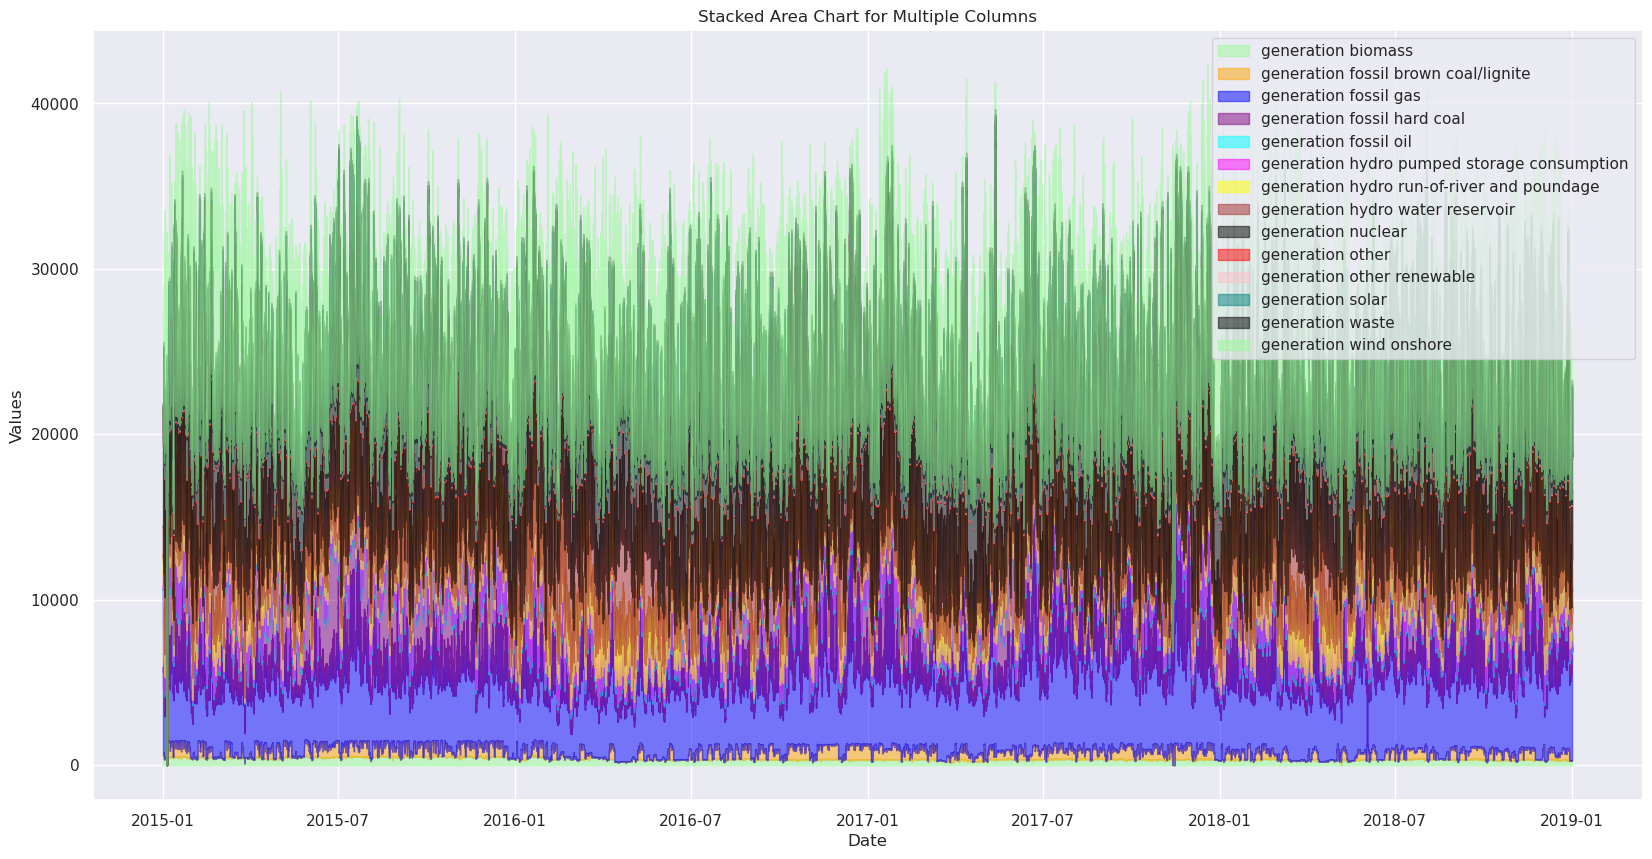

In [22]:
# For plotting, convert to Pandas (use with caution for large datasets)
# Consider sampling for large datasets: energy_graph_distribution.sample(0.1)
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas for plotting
pdf = energy_graph_distribution.orderBy('time').toPandas()
pdf = pdf.set_index('time')

# Define colors
colors = [
    'palegreen', 'orange', 'blue', 'purple', 'cyan', 'magenta', 'yellow',
    'brown', 'black', 'red', 'pink', 'teal', 'black'
]

plt.figure(figsize=(20, 10))

# Initialize a baseline series with zeros
baseline = pd.Series(0, index=pdf.index)

# Create stacked area chart
for i, column in enumerate(pdf.columns):
    plt.fill_between(pdf.index, baseline, baseline + pdf[column], 
                    label=column, alpha=0.5, color=colors[i % len(colors)])
    baseline += pdf[column]

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Stacked Area Chart for Multiple Columns')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
energy.show()

+-------------------+------------------+------------------------------------+---------------------+---------------------------+---------------------+-------------------------------------------+------------------------------------------+--------------------------------+------------------+----------------+--------------------------+----------------+----------------+-----------------------+-----------------+---------------+------------+
|               time|generation biomass|generation fossil brown coal/lignite|generation fossil gas|generation fossil hard coal|generation fossil oil|generation hydro pumped storage consumption|generation hydro run-of-river and poundage|generation hydro water reservoir|generation nuclear|generation other|generation other renewable|generation solar|generation waste|generation wind onshore|total load actual|price day ahead|price actual|
+-------------------+------------------+------------------------------------+---------------------+-------------------------

# Modelling


## Prophet Model for Load Actual

In [26]:
## Run this if prophet is not installed
# !pip install prophet
# !pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.2/365.2 kB 1.7 MB/s eta 0:00:0000:0100:01


In [24]:
# Prophet model for 'total load actual' column
from prophet import Prophet
import pandas as pd
from pyspark.sql.functions import col

# Select only time and total load actual columns
prophet_data = energy.select('time', 'total load actual')

# Convert to Pandas for Prophet (Prophet requires pandas DataFrame)
prophet_df = prophet_data.orderBy('time').toPandas()

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_df = prophet_df.rename(columns={'time': 'ds', 'total load actual': 'y'})

# Remove any remaining null values
prophet_df = prophet_df.dropna()

# Display data info
print(f"Data shape: {prophet_df.shape}")
print(f"Date range: {prophet_df['ds'].min()} to {prophet_df['ds'].max()}")
print(f"First few rows:")
print(prophet_df.head())

Data shape: (35064, 2)
Date range: 2014-12-31 23:00:00 to 2018-12-31 22:00:00
First few rows:
                   ds      y
0 2014-12-31 23:00:00  25385
1 2015-01-01 00:00:00  24382
2 2015-01-01 01:00:00  22734
3 2015-01-01 02:00:00  21286
4 2015-01-01 03:00:00  20264


In [25]:
# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',  # or 'additive'
    changepoint_prior_scale=0.05
)

# Fit the model
print("Fitting Prophet model...")
model.fit(prophet_df)

# Create future dataframe for forecasting
# Forecast for next 30 days (720 hours)
future = model.make_future_dataframe(periods=720, freq='H')  # hourly frequency

# Make predictions
print("Making predictions...")
forecast = model.predict(future)


Fitting Prophet model...


14:09:04 - cmdstanpy - INFO - Chain [1] start processing
14:09:25 - cmdstanpy - INFO - Chain [1] done processing


Making predictions...



Forecast columns:
['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat']

Forecast shape: (35784, 22)

Last few predictions:
                       ds          yhat    yhat_lower    yhat_upper
35774 2019-01-30 13:00:00  34360.324700  30863.776250  37852.321612
35775 2019-01-30 14:00:00  33643.343248  30431.045310  37252.947314
35776 2019-01-30 15:00:00  33201.270334  29778.967336  36650.101240
35777 2019-01-30 16:00:00  33399.479366  29852.036703  36793.450636
35778 2019-01-30 17:00:00  34194.704414  30685.701895  37839.519783
35779 2019-01-30 18:00:00  35038.887701  31709.015161  38563.387686
35780 2019-01-30 19:00:00  35199.845065  31714.405415  38668.101695
35781 2019-01-30 20:00:00  342

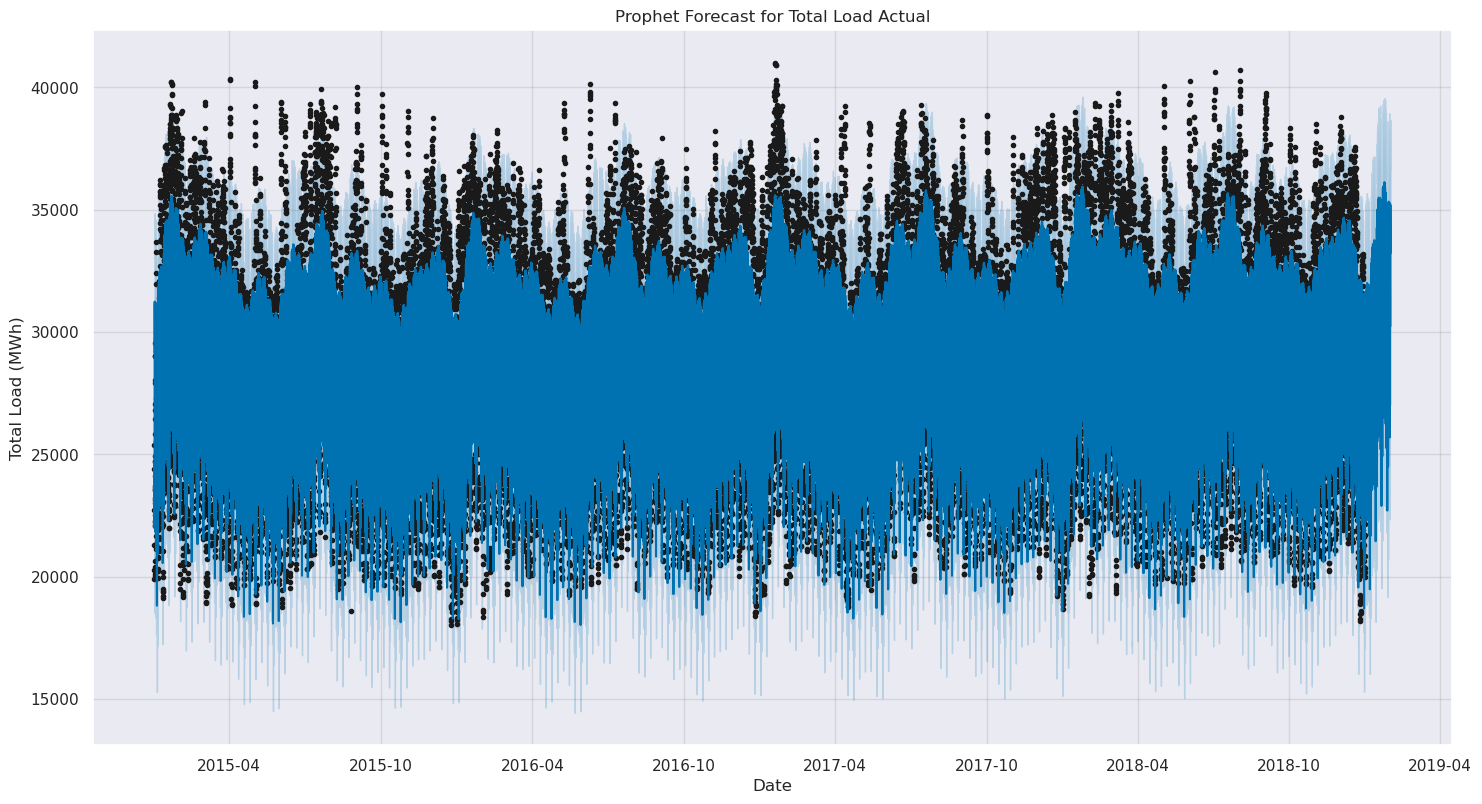

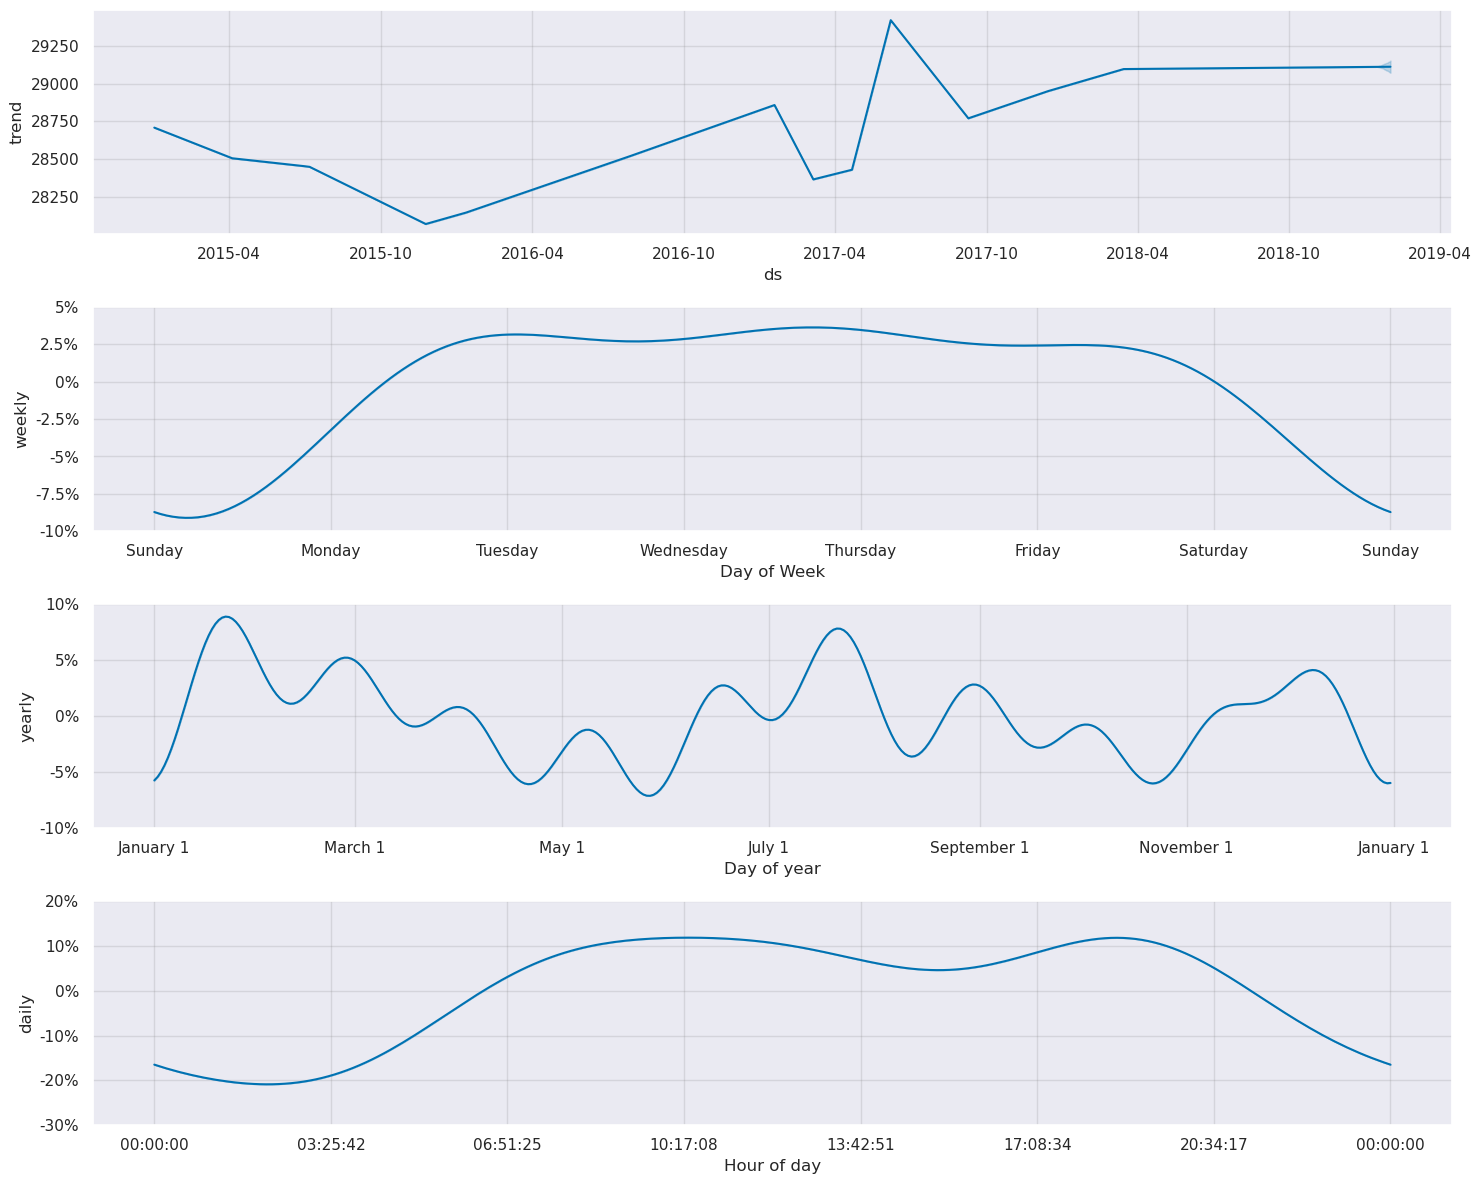


Model Performance Metrics:
MAE: 2009.92
RMSE: 2680.98
MAPE: 7.15%


In [26]:
# Display forecast results
print("\nForecast columns:")
print(forecast.columns.tolist())
print(f"\nForecast shape: {forecast.shape}")
print(f"\nLast few predictions:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# Plot the forecast
import matplotlib.pyplot as plt

# Plot forecast
fig1 = model.plot(forecast, figsize=(15, 8))
plt.title('Prophet Forecast for Total Load Actual')
plt.xlabel('Date')
plt.ylabel('Total Load (MWh)')
plt.show()

# Plot components
fig2 = model.plot_components(forecast, figsize=(15, 12))
plt.show()

# Calculate and display model performance metrics on training data
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get predictions for training period
train_predictions = forecast[forecast['ds'] <= prophet_df['ds'].max()]
train_predictions = train_predictions.merge(prophet_df, on='ds', how='inner')

mae = mean_absolute_error(train_predictions['y'], train_predictions['yhat'])
rmse = np.sqrt(mean_squared_error(train_predictions['y'], train_predictions['yhat']))
mape = np.mean(np.abs((train_predictions['y'] - train_predictions['yhat']) / train_predictions['y'])) * 100

print(f"\nModel Performance Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

In [27]:
# !pip install joblib
import joblib
# --- 3. Define the filename for saving your model ---
# It's common practice to use a .joblib or .pkl extension for joblib/pickle files.
model_filename = '/home/jovyan/work/mlmodels/prophet_model.joblib'

# --- 4. Save the trained Prophet model using joblib ---
# joblib.dump() serializes the Python object (your Prophet model)
# into a file, making it ready to be loaded later.
print(f"Saving Prophet model to: '{model_filename}'...")
try:
    joblib.dump(model, model_filename)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")
print("-" * 30)

Saving Prophet model to: '/home/jovyan/work/mlmodels/prophet_model.joblib'...
Model saved successfully!
------------------------------


In [28]:
print(f"Attempting to load Prophet model from: '{model_filename}'...")
loaded_model = None
try:
    # Ensure 'joblib' is imported and available in the current scope.
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully!")
    print(f"Type of loaded object: {type(loaded_model)}")

    # You can now use the loaded_model to make predictions or further analysis
    # For example, let's make a future dataframe and predict with the loaded model
    future_loaded = loaded_model.make_future_dataframe(periods=5, freq='H')
    forecast_loaded = loaded_model.predict(future_loaded)
    print("\nFirst few predictions from the loaded model:")
    print(forecast_loaded[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

except FileNotFoundError:
    print(f"Error: Model file '{model_filename}' not found. Make sure it was saved correctly in step 4.")
except NameError:
    print("Error: 'joblib' is not defined when attempting to load. Please ensure 'import joblib' is at the top of your script/cell and executed.")
except Exception as e:
    print(f"An unexpected error occurred while loading the model: {e}")
print("-" * 30)

Attempting to load Prophet model from: '/home/jovyan/work/mlmodels/prophet_model.joblib'...
Model loaded successfully!
Type of loaded object: <class 'prophet.forecaster.Prophet'>

First few predictions from the loaded model:
                   ds          yhat    yhat_lower    yhat_upper
0 2014-12-31 23:00:00  24650.996703  21000.010452  27743.998546
1 2015-01-01 00:00:00  23292.002581  19805.778096  26663.630011
2 2015-01-01 01:00:00  22423.924269  18934.033592  25756.130641
3 2015-01-01 02:00:00  22018.837248  18672.067447  25523.532055
4 2015-01-01 03:00:00  22219.139888  18640.011673  25859.614221
------------------------------


## Renewable Energy

In [34]:
#Agent
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek, month, col, to_timestamp
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import joblib

# Start Spark session
spark = SparkSession.builder.getOrCreate()

# Read CSV from HDFS
df = spark.read.csv(path+"/rmod.csv", header=True, inferSchema=True)
jupyter_path = "/home/jovyan/work/mlmodels" #path to save the models

# Parse time column and extract features
df = df.withColumn("time", to_timestamp(col("time")))
df = df.withColumn("hour", hour(col("time")))
df = df.withColumn("dayofweek", dayofweek(col("time")))  # Spark: 1=Sunday, 7=Saturday
df = df.withColumn("month", month(col("time")))

# Drop rows with missing values in relevant columns
for c in ["generation solar", "generation wind onshore", "forecast solar day ahead", "forecast wind onshore day ahead"]:
    df = df.filter(col(c).isNotNull())

# Select features and convert to pandas
feature_cols = [
    "forecast solar day ahead", "forecast wind onshore day ahead",
    "hour", "dayofweek", "month"
]

# For scikit-learn, convert to pandas
pdf = df.select(
    *feature_cols, "generation solar", "generation wind onshore"
).toPandas()

results = {}

for target in ["generation solar", "generation wind onshore"]:
    X = pdf[feature_cols]
    y = pdf[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    try:
        if(target == "generation solar"):
            joblib.dump(rf, jupyter_path+"/rf_model_solar.joblib")
            print("Random Forest model saved at: "+jupyter_path+"/rf_model_solar.joblib")
        else:
            joblib.dump(rf, jupyter_path+"/rf_model_wind.joblib")
            print("Random Forest model saved at: "+jupyter_path+"/rf_model_wind.joblib")
    except Exception as e:
        print("Error saving Random Forest model: "+str(e))
    
    y_pred_rf = rf.predict(X_test)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

    # Ridge Regression
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    try:
        if(target == "generation solar"):
            joblib.dump(ridge, jupyter_path+"/ridge_model_solar.joblib")
            print("Ridge model saved at: "+jupyter_path+"/ridge_model_solar.joblib")
        else:
            joblib.dump(ridge, jupyter_path+"/ridge_model_wind.joblib")
            print("Ridge model saved at: "+jupyter_path+"/ridge_model_wind.joblib")
    except Exception as e:
        print("Error saving Ridge model: "+str(e))
    y_pred_ridge = ridge.predict(X_test)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

    results[target] = {
        "RandomForest": {"MAE": mae_rf, "RMSE": rmse_rf},
        "Ridge": {"MAE": mae_ridge, "RMSE": rmse_ridge}
    }

# Display results
for target, res in results.items():
    print(f"\nResults for {target}:")
    for model, metrics in res.items():
        print(f"  {model}: MAE = {metrics['MAE']:.2f}, RMSE = {metrics['RMSE']:.2f}")

Random Forest model saved at: /home/jovyan/work/mlmodels/rf_model_solar.joblib
Ridge model saved at: /home/jovyan/work/mlmodels/ridge_model_solar.joblib
Random Forest model saved at: /home/jovyan/work/mlmodels/rf_model_wind.joblib
Ridge model saved at: /home/jovyan/work/mlmodels/ridge_model_wind.joblib

Results for generation solar:
  RandomForest: MAE = 115.48, RMSE = 193.92
  Ridge: MAE = 124.18, RMSE = 196.89

Results for generation wind onshore:
  RandomForest: MAE = 208.52, RMSE = 361.73
  Ridge: MAE = 186.06, RMSE = 355.28


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 37600)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =

## TS Forecasting

In [6]:
!pip install statsmodels

=== Load Forecasting with Your Energy Data ===

1. Loading your energy data...
Loading data from /home/jovyan/work/energy_data.csv...
Data shape: (35064, 27)
Columns: ['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']

First few rows:
                        time  generation biomass  \
0  2015-01-01 00:00:00+01:00     

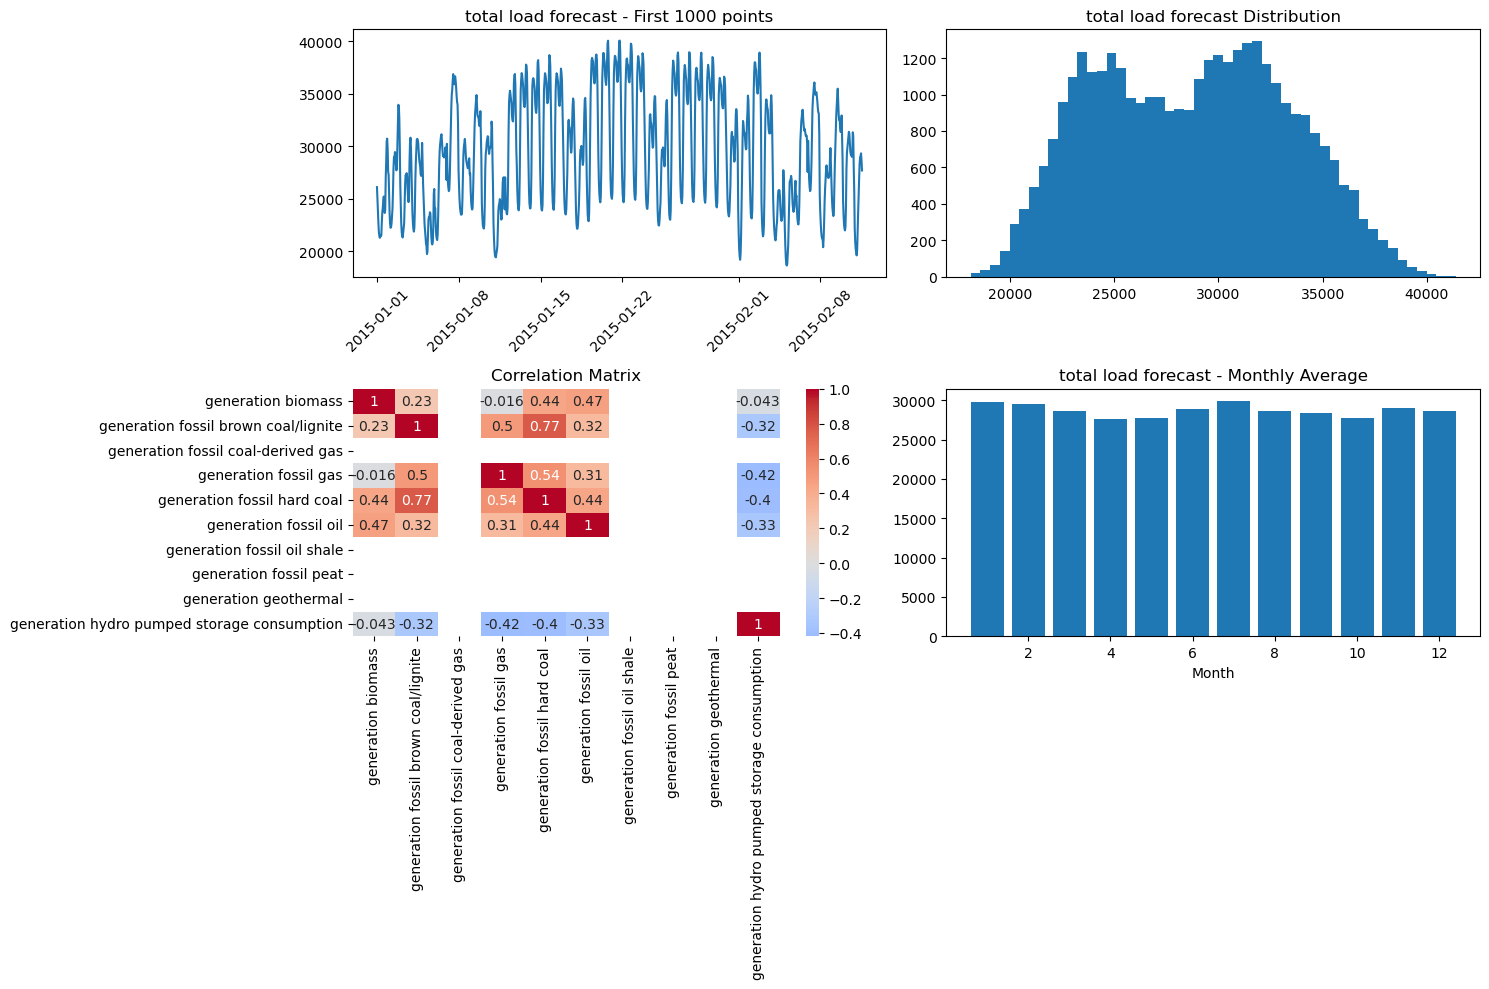


3. Preparing data for training...
Dropped 168 rows with missing values
Selected features (40): ['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage consumption']...
Training data: (27916, 40)
Test data: (6980, 40)
Target variable range: 18105.00 to 41390.00

4. Training model...
Training random_forest model...

Top 10 Most Important Features:
                     feature  importance
22         total load actual    0.984423
27                load_lag_1    0.008430
28               load_lag_24    0.000471
34                  hour_sin    0.000445
35                  hour_cos    0.000417
30      load_rolling_mean_24    0.000390
29              load_lag_168    0.000360
20  forecast solar day ahead    0.000302
32     load_rolling_mean_168    0.000284


"\n1. Make sure your CSV file is at './data/energy_data.csv'\n\n2. The script will automatically:\n   - Detect the time column (looks for columns with 'time' or 'date' in name)\n   - Detect the target column (looks for columns with 'load' in name)\n   - Create appropriate features\n   - Train and evaluate the model\n\n3. If the automatic detection doesn't work:\n   - Check the output of load_data() to see your column names\n   - Modify the prepare_data() call to specify target_column='your_column_name'\n\n4. The model will create time-based features and lag features automatically\n\n5. Results will be saved as 'energy_forecasting_model.pkl'\n"

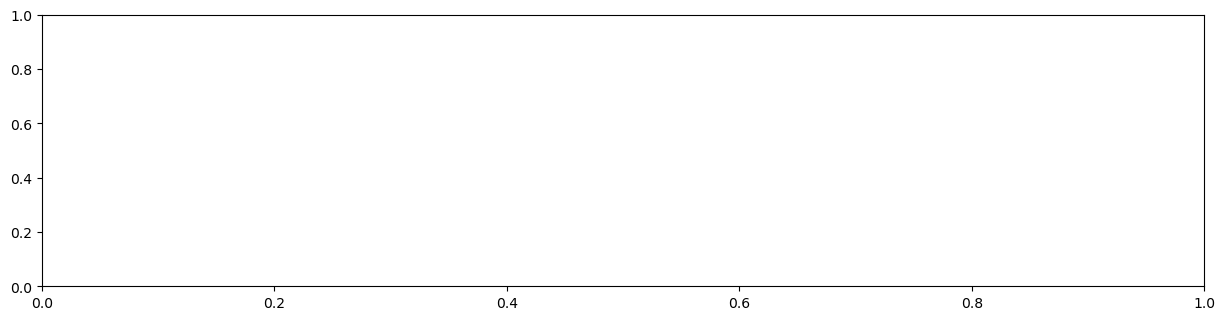

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series specific
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

class LoadForecastingModel:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.feature_columns = []
        self.model_type = None
        self.is_trained = False
        
    def load_data(self, file_path=None, data=None):
        """Load data from file or use provided data"""
        if data is not None:
            self.df = data.copy()
        else:
            # Load your CSV data
            print(f"Loading data from {file_path}...")
            try:
                self.df = pd.read_csv(file_path)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                return None
            except Exception as e:
                print(f"Error reading CSV file: {e}")
                return None
            
        # Display basic info about the dataset
        print(f"Data shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        print("\nFirst few rows:")
        print(self.df.head())
        
        # Try to identify the time column
        time_columns = [col for col in self.df.columns if 'time' in col.lower() or 'date' in col.lower()]
        if time_columns:
            time_col = time_columns[0]
            print(f"\nUsing '{time_col}' as time column")
        else:
            # If no obvious time column, assume first column or let user specify
            time_col = self.df.columns[0]
            print(f"\nNo obvious time column found. Using '{time_col}' as time column")
            print("If this is incorrect, please modify the code to specify the correct column")
        
        # Convert time column to datetime
        try:
            print(f"Converting '{time_col}' to datetime...")
            self.df[time_col] = pd.to_datetime(self.df[time_col])
            
            # Handle timezone-aware datetime
            if self.df[time_col].dt.tz is not None:
                print(f"Timezone-aware datetime detected. Converting to UTC and removing timezone info...")
                self.df[time_col] = self.df[time_col].dt.tz_convert('UTC').dt.tz_localize(None)
            
            self.df.set_index(time_col, inplace=True)
            print(f"Successfully set '{time_col}' as index")
        except Exception as e:
            print(f"Error converting time column: {e}")
            print("Attempting alternative datetime parsing...")
            try:
                # Try with different parsing options
                self.df[time_col] = pd.to_datetime(self.df[time_col], utc=True)
                self.df[time_col] = self.df[time_col].dt.tz_localize(None)
                self.df.set_index(time_col, inplace=True)
                print("Successfully parsed with UTC conversion")
            except Exception as e2:
                print(f"Second attempt failed: {e2}")
                print("Please check your time column format")
                print(f"Sample values from time column: {self.df[time_col].head()}")
                return None
            
        # Sort by time
        self.df.sort_index(inplace=True)
        
        # Check for load column
        load_columns = [col for col in self.df.columns if 'load' in col.lower()]
        if load_columns:
            self.target_column = load_columns[0]
            print(f"Found load column: '{self.target_column}'")
        else:
            print("No obvious load column found. Available columns:")
            for i, col in enumerate(self.df.columns):
                print(f"{i}: {col}")
            print("Please specify the target column name in the prepare_data method")
        
        print(f"\nData loaded successfully. Shape: {self.df.shape}")
        print(f"Date range: {self.df.index.min()} to {self.df.index.max()}")
        return self.df
    
    def explore_data(self):
        """Explore the loaded data"""
        if self.df is None:
            print("No data loaded!")
            return
        
        print("=== Data Exploration ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Date range: {self.df.index.min()} to {self.df.index.max()}")
        print(f"Frequency: {pd.infer_freq(self.df.index)}")
        
        print("\nColumn statistics:")
        print(self.df.describe())
        
        print("\nMissing values:")
        print(self.df.isnull().sum())
        
        # Plot some basic visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time series plot
        if hasattr(self, 'target_column'):
            axes[0, 0].plot(self.df.index[:1000], self.df[self.target_column][:1000])
            axes[0, 0].set_title(f'{self.target_column} - First 1000 points')
            axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Distribution plot
        if hasattr(self, 'target_column'):
            axes[0, 1].hist(self.df[self.target_column].dropna(), bins=50)
            axes[0, 1].set_title(f'{self.target_column} Distribution')
        
        # Correlation heatmap
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns[:10]  # First 10 numeric columns
        if len(numeric_cols) > 1:
            corr_matrix = self.df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
            axes[1, 0].set_title('Correlation Matrix')
        
        # Monthly pattern (if enough data)
        if hasattr(self, 'target_column') and len(self.df) > 100:
            monthly_avg = self.df[self.target_column].groupby(self.df.index.month).mean()
            axes[1, 1].bar(monthly_avg.index, monthly_avg.values)
            axes[1, 1].set_title(f'{self.target_column} - Monthly Average')
            axes[1, 1].set_xlabel('Month')
        
        plt.tight_layout()
        plt.show()
    
    def create_features(self):
        """Create time-based and lag features"""
        df = self.df.copy()
        
        # Time-based features
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
        df['is_business_hour'] = ((df.index.hour >= 8) & (df.index.hour <= 18)).astype(int)
        
        # Only create lag features if we have a target column
        if hasattr(self, 'target_column') and self.target_column in df.columns:
            # Lag features for load
            for lag in [1, 24, 168]:  # 1 hour, 1 day, 1 week
                df[f'load_lag_{lag}'] = df[self.target_column].shift(lag)
            
            # Rolling statistics
            for window in [24, 168]:  # 1 day, 1 week
                df[f'load_rolling_mean_{window}'] = df[self.target_column].rolling(window=window).mean()
                df[f'load_rolling_std_{window}'] = df[self.target_column].rolling(window=window).std()
        
        # Cyclical encoding for time features
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        
        # Drop rows with NaN (due to lag features)
        initial_shape = df.shape[0]
        df.dropna(inplace=True)
        final_shape = df.shape[0]
        
        if initial_shape != final_shape:
            print(f"Dropped {initial_shape - final_shape} rows with missing values")
        
        self.processed_df = df
        return df
    
    def prepare_data(self, target_column=None):
        """Prepare data for training"""
        # Use specified target column or auto-detected one
        if target_column is None:
            if hasattr(self, 'target_column'):
                target_column = self.target_column
            else:
                print("Please specify target_column parameter")
                return None
        
        df = self.create_features()
        
        if target_column not in df.columns:
            print(f"Target column '{target_column}' not found in data!")
            print(f"Available columns: {list(df.columns)}")
            return None
        
        # Define feature columns (exclude target and some original columns)
        exclude_cols = [target_column]
        # Exclude non-numeric columns and original time features that might cause issues
        exclude_cols.extend(['hour', 'day_of_week', 'month', 'quarter'])  # Keep cyclical versions instead
        
        self.feature_columns = [col for col in df.columns 
                               if col not in exclude_cols 
                               and df[col].dtype in ['int64', 'float64', 'int32', 'float32']]
        
        print(f"Selected features ({len(self.feature_columns)}): {self.feature_columns[:10]}...")
        
        X = df[self.feature_columns]
        y = df[target_column]
        
        # Check for any remaining missing values
        if X.isnull().sum().sum() > 0:
            print("Warning: Found missing values in features. Filling with median values.")
            X = X.fillna(X.median())
        
        # Split data (80% train, 20% test)
        split_idx = int(len(df) * 0.8)
        
        self.X_train = X.iloc[:split_idx]
        self.X_test = X.iloc[split_idx:]
        self.y_train = y.iloc[:split_idx]
        self.y_test = y.iloc[split_idx:]
        
        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"Training data: {self.X_train.shape}")
        print(f"Test data: {self.X_test.shape}")
        print(f"Target variable range: {y.min():.2f} to {y.max():.2f}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def train_model(self, model_type='random_forest'):
        """Train the forecasting model"""
        print(f"Training {model_type} model...")
        
        if model_type == 'random_forest':
            self.model = RandomForestRegressor(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )
            self.model.fit(self.X_train_scaled, self.y_train)
            
        elif model_type == 'gradient_boosting':
            self.model = GradientBoostingRegressor(
                n_estimators=100,
                random_state=42
            )
            self.model.fit(self.X_train_scaled, self.y_train)
            
        elif model_type == 'linear_regression':
            self.model = LinearRegression()
            self.model.fit(self.X_train_scaled, self.y_train)
        
        self.model_type = model_type
        self.is_trained = True
        
        # Show feature importance if available
        if hasattr(self.model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\nTop 10 Most Important Features:")
            print(feature_importance.head(10))
        
        # Evaluate model
        self.evaluate_model()
        
        print(f"{model_type} model trained successfully!")
        return self.model
    
    def evaluate_model(self):
        """Evaluate model performance"""
        if not self.is_trained:
            print("Model not trained yet!")
            return
        
        # Make predictions
        y_pred_train = self.model.predict(self.X_train_scaled)
        y_pred_test = self.model.predict(self.X_test_scaled)
        
        # Calculate metrics
        train_mae = mean_absolute_error(self.y_train, y_pred_train)
        test_mae = mean_absolute_error(self.y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(self.y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
        train_r2 = r2_score(self.y_train, y_pred_train)
        test_r2 = r2_score(self.y_test, y_pred_test)
        
        print("\n=== Model Performance ===")
        print(f"Training MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
        print(f"Training RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Training R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        train_mape = np.mean(np.abs((self.y_train - y_pred_train) / self.y_train)) * 100
        test_mape = np.mean(np.abs((self.y_test - y_pred_test) / self.y_test)) * 100
        print(f"Training MAPE: {train_mape:.2f}%")
        print(f"Test MAPE: {test_mape:.2f}%")
        
        return {
            'train_mae': train_mae, 'test_mae': test_mae,
            'train_rmse': train_rmse, 'test_rmse': test_rmse,
            'train_r2': train_r2, 'test_r2': test_r2,
            'train_mape': train_mape, 'test_mape': test_mape
        }
    
    def plot_results(self):
        """Plot model predictions vs actual values"""
        if not self.is_trained:
            print("Model not trained yet!")
            return
        
        y_pred_test = self.model.predict(self.X_test_scaled)
        
        plt.figure(figsize=(15, 12))
        
        # Plot time series comparison
        plt.subplot(3, 1, 1)
        n_points = min(500, len(self.y_test))  # Show last N points for visibility
        test_dates = self.y_test.index[-n_points:]
        plt.plot(test_dates, self.y_test.iloc[-n_points:], label='Actual', alpha=0.7)
        plt.plot(test_dates, y_pred_test[-n_points:], label='Predicted', alpha=0.7)
        plt.title(f'Load Forecasting: Actual vs Predicted (Last {n_points} Points)')
        plt.xlabel('Date')
        plt.ylabel('Load')
        plt.legend()
        plt.xticks(rotation=45)
        
        # Scatter plot
        plt.subplot(3, 1, 2)
        plt.scatter(self.y_test, y_pred_test, alpha=0.5)
        plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Load')
        plt.ylabel('Predicted Load')
        plt.title('Actual vs Predicted Load (Scatter Plot)')
        
        # Residuals plot
        plt.subplot(3, 1, 3)
        residuals = self.y_test - y_pred_test
        plt.scatter(y_pred_test, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Load')
        plt.ylabel('Residuals')
        plt.title('Residuals Plot')
        
        plt.tight_layout()
        plt.show()
    
    def predict_single(self, target_datetime, additional_features=None):
        """Predict load for a specific datetime"""
        if not self.is_trained:
            print("Model not trained yet!")
            return None
        
        # Convert string to datetime if needed
        if isinstance(target_datetime, str):
            target_datetime = pd.to_datetime(target_datetime)
        
        # Create a temporary dataframe for the target datetime
        temp_df = pd.DataFrame(index=[target_datetime])
        
        # Add time-based features
        temp_df['is_weekend'] = int(target_datetime.dayofweek >= 5)
        temp_df['is_business_hour'] = int(8 <= target_datetime.hour <= 18)
        
        # Cyclical encoding
        temp_df['hour_sin'] = np.sin(2 * np.pi * target_datetime.hour / 24)
        temp_df['hour_cos'] = np.cos(2 * np.pi * target_datetime.hour / 24)
        temp_df['day_sin'] = np.sin(2 * np.pi * target_datetime.dayofweek / 7)
        temp_df['day_cos'] = np.cos(2 * np.pi * target_datetime.dayofweek / 7)
        temp_df['month_sin'] = np.sin(2 * np.pi * target_datetime.month / 12)
        temp_df['month_cos'] = np.cos(2 * np.pi * target_datetime.month / 12)
        
        # For other features, use mean values from training data or provided values
        for col in self.feature_columns:
            if col not in temp_df.columns:
                if additional_features and col in additional_features:
                    temp_df[col] = additional_features[col]
                else:
                    # Use mean value for missing features
                    temp_df[col] = self.processed_df[col].mean() if col in self.processed_df.columns else 0
        
        # Ensure all feature columns are present and in correct order
        temp_df = temp_df.reindex(columns=self.feature_columns, fill_value=0)
        
        # Scale features
        features_scaled = self.scaler.transform(temp_df)
        
        # Make prediction
        prediction = self.model.predict(features_scaled)[0]
        
        print(f"Predicted load for {target_datetime}: {prediction:.2f}")
        return prediction
    
    def save_model(self, filename='load_forecasting_model.pkl'):
        """Save the trained model and scaler"""
        if not self.is_trained:
            print("Model not trained yet!")
            return
        
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_columns': self.feature_columns,
            'model_type': self.model_type,
            'processed_df': self.processed_df
        }
        
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved as {filename}")
    
    def load_model(self, filename='load_forecasting_model.pkl'):
        """Load a saved model"""
        try:
            with open(filename, 'rb') as f:
                model_data = pickle.load(f)
            
            self.model = model_data['model']
            self.scaler = model_data['scaler']
            self.feature_columns = model_data['feature_columns']
            self.model_type = model_data['model_type']
            self.processed_df = model_data['processed_df']
            self.is_trained = True
            
            print(f"Model loaded from {filename}")
            return True
        except FileNotFoundError:
            print(f"Model file {filename} not found!")
            return False

# Main execution function
def main():
    print("=== Load Forecasting with Your Energy Data ===\n")
    
    # Initialize model
    forecaster = LoadForecastingModel()
    
    # Load your actual data
    print("1. Loading your energy data...")
    try:
        forecaster.load_data('/home/jovyan/work/energy_data.csv')
        # Explore the data
        print("\n2. Exploring the data...")
        forecaster.explore_data()
        
        # Prepare data for training
        print("\n3. Preparing data for training...")
        # You may need to specify the correct target column name here
        # Check the output from load_data() to see available columns
        forecaster.prepare_data()
        
        # Train model
        print("\n4. Training model...")
        forecaster.train_model(model_type='random_forest')
        
        # Plot results
        print("\n5. Plotting results...")
        forecaster.plot_results()
        
        # Make some sample predictions
        print("\n6. Making sample predictions...")
        # Use dates that make sense for your data range
        sample_dates = [
            '2023-01-15 14:00:00',
            '2023-06-20 09:30:00',
            '2023-12-25 20:15:00'
        ]
        
        for date in sample_dates:
            try:
                forecaster.predict_single(date)
            except:
                print(f"Could not predict for {date} (date might be outside data range)")
        
        # Save model
        print("\n7. Saving model...")
        forecaster.save_model('/home/jovyan/work/energy_forecasting_model.pkl')
        
        print("\n=== Model training complete! ===")
        
    except Exception as e:
        print(f"Error: {e}")
        print("Please check that your data file exists and is in the correct format.")
        print("Expected: CSV file with time column and load/energy columns")

if __name__ == "__main__":
    main()

# Instructions for usage with your data:
"""
1. Make sure your CSV file is at './data/energy_data.csv'

2. The script will automatically:
   - Detect the time column (looks for columns with 'time' or 'date' in name)
   - Detect the target column (looks for columns with 'load' in name)
   - Create appropriate features
   - Train and evaluate the model

3. If the automatic detection doesn't work:
   - Check the output of load_data() to see your column names
   - Modify the prepare_data() call to specify target_column='your_column_name'

4. The model will create time-based features and lag features automatically

5. Results will be saved as 'energy_forecasting_model.pkl'
"""

In [11]:
dff = pd.read_csv('/home/jovyan/work/energy_data.csv')
dff.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,1-1-15 0:00,447,329,0,4844,4821,162,0,0,0,...,49,196,0,6378,17,6436,26118,25385,50.10,65.41
1,1-1-15 1:00,449,328,0,5196,4755,158,0,0,0,...,50,195,0,5890,16,5856,24934,24382,48.10,64.92
2,1-1-15 2:00,448,323,0,4857,4581,157,0,0,0,...,50,196,0,5461,8,5454,23515,22734,47.33,64.48
3,1-1-15 3:00,438,254,0,4314,4131,160,0,0,0,...,50,191,0,5238,2,5151,22642,21286,42.27,59.32
4,1-1-15 4:00,428,187,0,4130,3840,156,0,0,0,...,42,189,0,4935,9,4861,21785,20264,38.41,56.04
